In [1]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
market_data = pd.read_parquet('data/US/mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['close'].unstack().reindex_like(P).pct_change()
market_data.head()

,,datetime,open,high,low,close,adj_close,volume,MktCap
Date,Ticker,,,,,,,,
2008-01-02,A,2008-01-02,36.6587,36.7886,36.1089,36.2888,23.4977,1858900,NaN
2008-01-03,A,2008-01-03,36.2888,36.3388,35.8589,35.9289,23.2647,1995302,NaN
2008-01-04,A,2008-01-04,35.5690,35.8389,34.7093,34.7593,22.5073,3533080,NaN
2008-01-07,A,2008-01-07,35.3291,35.8689,35.0392,35.3291,22.8763,3505732,NaN
2008-01-08,A,2008-01-08,35.3491,35.7390,35.1392,35.2791,22.8439,4063445,NaN


In [3]:
earnings = pd.read_parquet('data/US/earnings.pq')
earnings['Date'] = pd.to_datetime(earnings['reportDate'])
earnings = earnings.droplevel(0).set_index('Date',append=True)
earnings = earnings.reorder_levels(['Date','Ticker'])
earnings = earnings[~earnings.index.duplicated(keep='first')]
earnings = earnings[earnings['epsActual'].notna()]
earnings.head()

,,reportDate,date,beforeAfterMarket,currency,epsActual,epsEstimate,epsDifference,surprisePercent
Date,Ticker,,,,,,,,
2000-02-17,A,2000-02-17,2000-01-31,None,USD,0.30,0.22,0.08,36.3636
2000-05-16,A,2000-05-16,2000-04-30,None,USD,0.35,0.32,0.03,9.3750
2000-08-17,A,2000-08-17,2000-07-31,None,USD,0.39,0.20,0.19,95.0000
2000-11-20,A,2000-11-20,2000-10-31,None,USD,0.73,0.54,0.19,35.1852
2001-02-20,A,2001-02-20,2001-01-31,None,USD,0.51,0.45,0.06,13.3333


In [4]:
eps_actual =  earnings['epsActual'].unstack().reindex_like(P)
eps_actual = eps_actual[P].ffill().astype(float).rank(1,pct=True,ascending=True).apply(norm.ppf)
eps_estimate =  earnings['epsEstimate'].unstack().reindex_like(P)
eps_estimate = eps_estimate[P].ffill().astype(float).rank(1,pct=True,ascending=True).apply(norm.ppf)
eps_estimate.stack().sample(5)

            Ticker
2016-05-30  LNT      -0.508349
2010-05-07  VRSN     -0.132054
2014-06-09  URBN     -0.334660
2013-02-19  CPT      -0.434113
2009-01-27  CLX       0.680797
dtype: float64

In [5]:
def oscillator(high,
                low,
                close,
                fast=None,
                medium=None,
                slow=None,
                fast_w=None,
                medium_w=None,
                slow_w=None,
                drift=1,
                offset=0, 
                **kwargs):
    
    """Indicator: Ultimate Oscillator (UO)"""
    # Validate arguments
    fast = int(fast) if fast and fast > 0 else 5
    fast_w = float(fast_w) if fast_w and fast_w > 0 else 5.0
    medium = int(medium) if medium and medium > 0 else 15
    medium_w = float(medium_w) if medium_w and medium_w > 0 else 2.0
    slow = int(slow) if slow and slow > 0 else 20
    slow_w = float(slow_w) if slow_w and slow_w > 0 else 1.0
    if high is None or low is None or close is None: return

    tdf = pd.DataFrame({
        "high": high,
        "low": low,
        f"close_{drift}": close.shift(drift)
    })
    max_h_or_pc = tdf.loc[:, ["high", f"close_{drift}"]].max(axis=1)
    min_l_or_pc = tdf.loc[:, ["low", f"close_{drift}"]].min(axis=1)
    del tdf

    bp = close - min_l_or_pc
    tr = max_h_or_pc - min_l_or_pc

    fast_avg = bp.rolling(fast).sum() / tr.rolling(fast).sum()
    medium_avg = bp.rolling(medium).sum() / tr.rolling(medium).sum()
    slow_avg = bp.rolling(slow).sum() / tr.rolling(slow).sum()

    total_weight = fast_w + medium_w + slow_w
    weights = (fast_w * fast_avg) + (medium_w * medium_avg) + (slow_w * slow_avg)
    uo = 100 * weights / total_weight

    # Offset
    if offset != 0:
        uo = uo.shift(offset)

    # Handle fills
    if "fillna" in kwargs:
        uo.fillna(kwargs["fillna"], inplace=True)
    if "fill_method" in kwargs:
        uo.fillna(method=kwargs["fill_method"], inplace=True)

    return uo

In [6]:
results ={}
for ticker in tqdm(market_data.index.get_level_values(1).unique()):
    try :
        metrics = oscillator(eps_actual[ticker].rolling(21).max(),eps_estimate[ticker].rolling(21).mean(),eps_actual[ticker],1).fillna(0)
        results[ticker] = metrics
    except :
        pass
metrics = pd.concat(results,axis=1).reindex_like(P).ffill()


100%|██████████| 866/866 [00:03<00:00, 244.82it/s]


C:\Users\marti\AppData\Local\Temp\ipykernel_10548\1966472611.py:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicsect'],axis=1).apply(center)


Sharpe                         1.4
Average Daily Turnover (%)    44.3
Average Daily PNL (bp)         1.5
dtype: float64

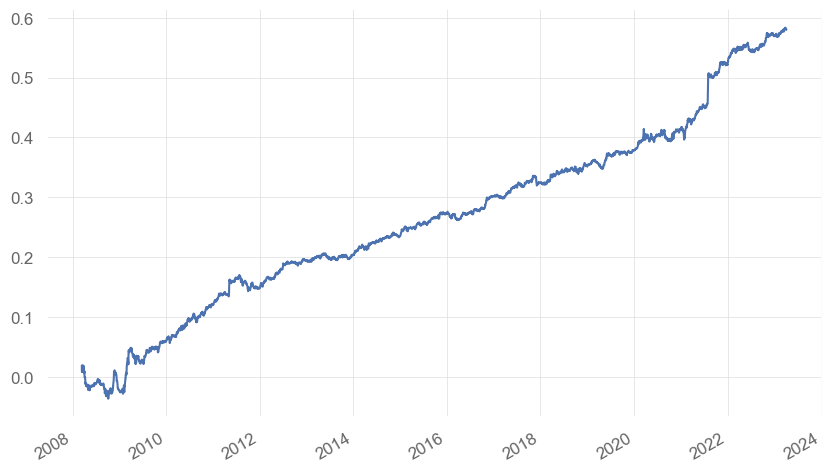

In [14]:
signal = metrics[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf) ## cross sectionnal rank
signal[signal.abs()<0.4] = None ## not playing stocks in the middle of the distribution

signal = signal[P].groupby(GICS['gicsect'],axis=1).apply(center) ## hedge by Gics sector
signal = signal[P].div(signal[P].abs().sum(1),0) ## constant GMV

PNL = (signal[P].shift()*R).sum(1)
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,'Average Daily Turnover (%)':turnover *100,'Average Daily PNL (bp)':PNL.mean()*1e4}).round(1)

Text(0, 0.5, ' # stocks held in portfolio')

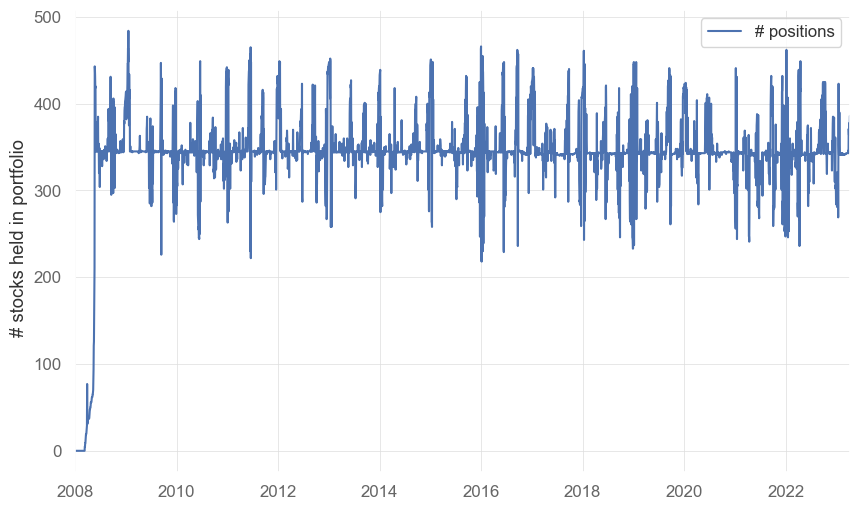

In [17]:
signal.count(1).plot(label ='# positions',legend=True)
plt.ylabel(' # stocks held in portfolio')

<Axes: >

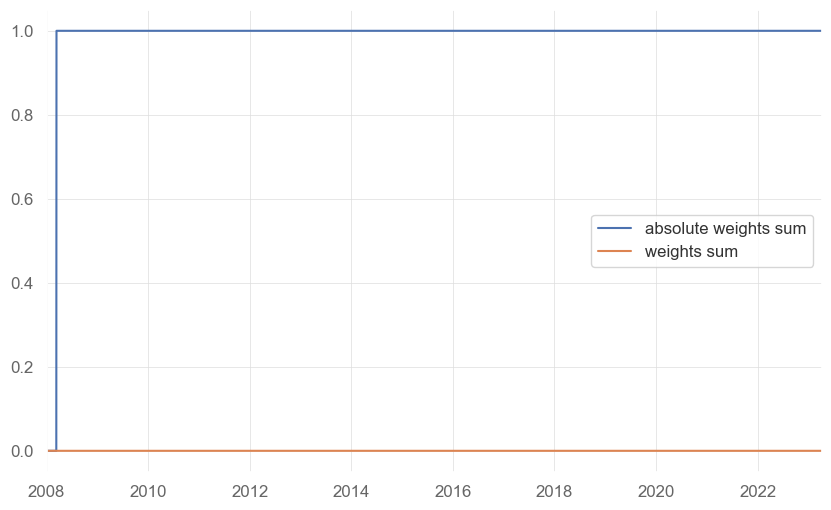

In [18]:
signal.abs().sum(1).plot(label = 'absolute weights sum',legend=True)
signal.sum(1).plot(label='weights sum',legend=True)